Временные ряды - финальный проект
====

Основное задание
---

В данном проекте главной задачей будет построить алгоритм, определяющий поиски аномалий.

Можно так же сделать симуляцию своей системы, то есть проверить, как система работала бы в продакшине, какие данные она бы использовала для перетренировки и как часто эта перетренировка бы соврешалась.

**На выбор** у вас два датасета. Один имеет много данных, а второй  временной ряд наоборот, содержат в себе еще очень мало информации. Вы так же можете использовать и другие датасеты из тех, что у вас есть в доступе на гитхабе. Но тогда вам прийдется сформулировать и ту задачу, которую вы пытаетесь решить, а именно пояснить, зачем в данном случае нам нужен поиск аномалий и как это будет применено на практике. 


Датасеты
------

Пассажиропоток нью-йоркского такси
--


In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 10)})
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")
from pmdarima import auto_arima 
import pandas as pd 
import numpy as np
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from plotly.subplots import make_subplots


from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.arima.model  import ARIMA


import statsmodels.api as sm

In [2]:
df = pd.read_csv('datatest/nyc_taxi.csv')
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df.set_index('timestamp',inplace=True)
df = df.resample('H').sum()

df

,value
timestamp,
2014-07-01 00:00:00,18971
2014-07-01 01:00:00,10866
2014-07-01 02:00:00,6693
2014-07-01 03:00:00,4433
2014-07-01 04:00:00,4379
...,...
2015-01-31 19:00:00,56577
2015-01-31 20:00:00,48276
2015-01-31 21:00:00,48389


In [4]:
df = df.reset_index()
df['day'] = df['timestamp'].dt.dayofweek # добываю фичи, которые нужны для анализа
df['hour'] = df['timestamp'].dt.hour 

df.set_index('timestamp',inplace=True)

df

,value,day,hour
timestamp,,,
2014-07-01 00:00:00,18971,1,0
2014-07-01 01:00:00,10866,1,1
2014-07-01 02:00:00,6693,1,2
2014-07-01 03:00:00,4433,1,3
2014-07-01 04:00:00,4379,1,4
...,...,...,...
2015-01-31 19:00:00,56577,5,19
2015-01-31 20:00:00,48276,5,20
2015-01-31 21:00:00,48389,5,21


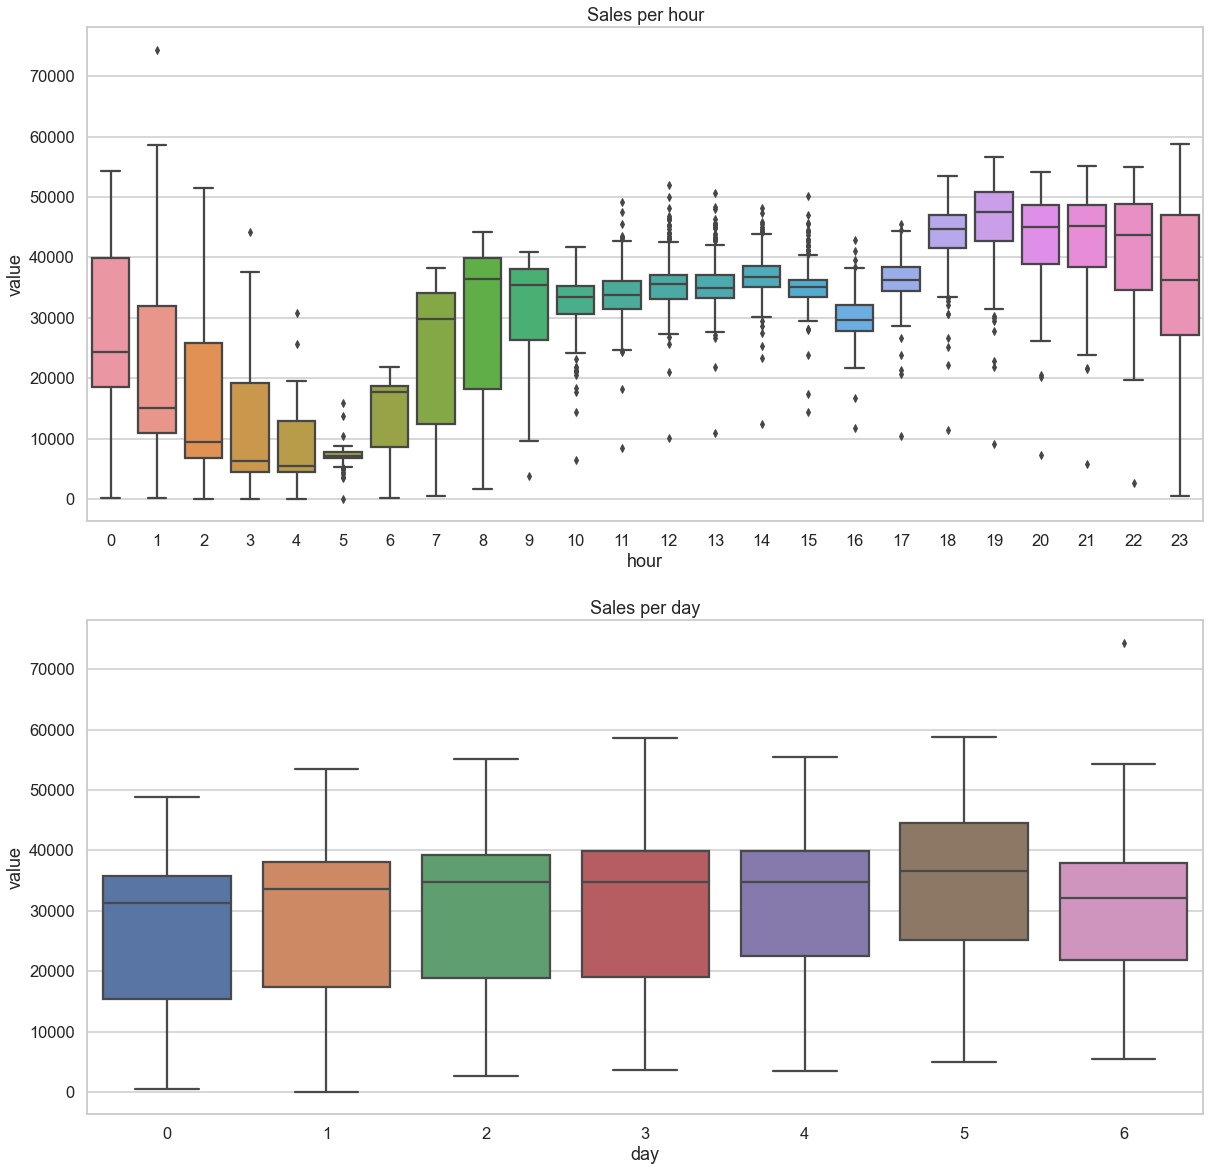

In [5]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 1, 1)
sns.boxplot(x='hour', y='value', data=df)
plt.title('Sales per hour')
plt.xlabel('hour')

plt.subplot(2, 1, 2)
sns.boxplot(x='day', y='value', data=df)
plt.title('Sales per day')
plt.xlabel('day')

plt.show()


In [6]:
df['avg'] = ''
df['std'] = ''
df['is_outlier'] = ''

for i in range(8):
    for j in range(25):
       # avg_vals = df[(df['day']==i) & (df['hour']==j)]['value'].mean() # ищу среднее значение за этот час, что бы потом сравнивать итаким образом находить аномалии
        mask = (df['day']==i) & (df['hour']==j)
        avg_vals = df[mask]['value'].mean()
        df.loc[mask, 'avg'] = avg_vals
        df.loc[mask, 'std'] = df['value'].std(axis=0)
        
        
        avg_vals = 0
        
        
df[(df['day']==3) & (df['hour']==14)] # для примера, что бы проверить

,value,day,hour,avg,std,is_outlier
timestamp,,,,,,
2014-07-03 14:00:00,38441,3,14,36372.290323,13759.780861,
2014-07-10 14:00:00,36586,3,14,36372.290323,13759.780861,
2014-07-17 14:00:00,38669,3,14,36372.290323,13759.780861,
2014-07-24 14:00:00,37161,3,14,36372.290323,13759.780861,
2014-07-31 14:00:00,36151,3,14,36372.290323,13759.780861,
2014-08-07 14:00:00,36303,3,14,36372.290323,13759.780861,
2014-08-14 14:00:00,35526,3,14,36372.290323,13759.780861,
2014-08-21 14:00:00,37140,3,14,36372.290323,13759.780861,
2014-08-28 14:00:00,34342,3,14,36372.290323,13759.780861,


In [13]:
# df['d'] = np.where(df.c > df.b, 'Type a', 'Type b')
    
df['is_outlier'] = np.where(((df['avg'] - df['std']*2)<df['value'])and(df['value']>(df['avg'] + df['std']*2)), '0', '1')

df

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [12]:
(df['avg'] - df['std']*2)<df['value']>(df['avg'] + df['std']*2)

timestamp
2014-07-01 00:00:00    True
2014-07-01 01:00:00    True
2014-07-01 02:00:00    True
2014-07-01 03:00:00    True
2014-07-01 04:00:00    True
                       ... 
2015-01-31 19:00:00    True
2015-01-31 20:00:00    True
2015-01-31 21:00:00    True
2015-01-31 22:00:00    True
2015-01-31 23:00:00    True
Length: 5160, dtype: bool

In [ ]:
fig = px.box(df[(df['day']==2)&(df['hour']==14)], x='hour', y='value')
fig.show()


На ящиках с усами сверху хорошо видны выбросы и общая тенденция: 
* изо дня в день и от месяца к месяцу значения вобщем не очень менются
* а вот зависимость от часа - значительная

In [ ]:
df[df['3'] < 0.4]

In [ ]:
print(df['value'].mean() - 3 * df['value'].std(), df['value'].mean() + 3 * df['value'].std())